# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, Add
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

In [0]:
def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    'convolutional layer which always uses the batch normalization layer'
    conv = Conv2D(filters, kernel_size, kernel_initializer='he_normal', padding=padding, strides=strides)(x)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    return conv

def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
    res = conv_block(x, filters, kernel_size, padding, strides)
    res = conv_block(res, filters, kernel_size, padding, strides)
    output = Add()([x, res])
    return output

In [0]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

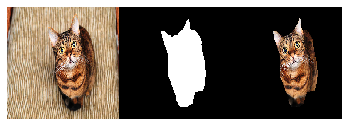

In [7]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [0]:
# Custom Loss Function

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_pred = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

# Model

In [0]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #Contracting layers
  nKernels = 8
  layers = []

  # level_1 (256, 256, 8)
  layer11 = Conv2D(nKernels, 1, activation='relu', padding='same', kernel_initializer='he_normal') (x)
  layer11 = residual_block(layer11, nKernels)
  layers.append(layer11)  # levels[0]
  layer13 = MaxPooling2D() (layer11)
  
  # level_2 (128, 128, 16)
  layer21 = Conv2D(nKernels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer13)
  layer21 = residual_block(layer21, nKernels*2)
  layers.append(layer21)   # levels[1]
  layer23 = MaxPooling2D() (layer21)

  # level_3 (64, 64, 32)
  layer31 = Conv2D(nKernels*4, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer23)
  layer31 = residual_block(layer31, nKernels*4)
  layers.append(layer31)   # levels[2]
  layer33 = MaxPooling2D() (layer31)

  # level_4 (32, 32, 64)
  layer41 = Conv2D(nKernels*8, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer33)
  layer41 = residual_block(layer41, nKernels*8)
  layers.append(layer41)   # levels[3]
  layer43 = MaxPooling2D() (layer41)

  # level_5 (16, 16, 128)
  layer51 = Conv2D(nKernels*16, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer43)
  layer51 = residual_block(layer51, nKernels*16)
  layers.append(layer51)   # levels[4]
  layer53 = MaxPooling2D() (layer51)

  # level_6 (8, 8, 256)
  layer61 = Conv2D(nKernels*32, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer53)
  layer61 = residual_block(layer61, nKernels*32)
  layers.append(layer61)   # levels[5]
  layer63 = MaxPooling2D() (layer61)
  
  # BottleNeck (4, 4, 512)
  bottleneck11 = Conv2D(nKernels*64, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer63)
  bottleneck11 = residual_block(bottleneck11, nKernels*64)
  bottleneck13 = Conv2DTranspose(nKernels*32, 2, strides=(2, 2), padding='same') (bottleneck11)
  level = len(layers) - 1
  layer71 = Concatenate(axis=3)([bottleneck13, layers[level]])
  
  # level 7 = level 6
  layer72 = Conv2D(nKernels*32, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer71)
  layer72 = residual_block(layer72, nKernels*32)
  layer74 = Conv2DTranspose(nKernels*16, 2, strides=(2, 2), padding='same') (layer72)
  level = len(layers) - 2
  layer81 = Concatenate(axis=3)([layer74, layers[level]])
  
  # level 8 = level 5
  layer82 = Conv2D(nKernels*16, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer81)
  layer82 = residual_block(layer82, nKernels*16)
  layer84 = Conv2DTranspose(nKernels*8, 2, strides=(2, 2), padding='same') (layer82)
  level = len(layers) - 3
  layer91 = Concatenate(axis=3)([layer84, layers[level]])

  # level 9 = level 4
  layer92 = Conv2D(nKernels*8, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer91)
  layer92 = residual_block(layer92, nKernels*8)
  layer94 = Conv2DTranspose(nKernels*4, 2, strides=(2, 2), padding='same') (layer92)
  level = len(layers) - 4
  layer101 = Concatenate(axis=3)([layer94, layers[level]])

  # level 10 = level 3
  layer102 = Conv2D(nKernels*4, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer101)
  layer102 = residual_block(layer102, nKernels*4)
  layer104 = Conv2DTranspose(nKernels*2, 2, strides=(2, 2), padding='same') (layer102)
  level = len(layers) - 5
  layer111 = Concatenate(axis=3)([layer104, layers[level]])
  
  # level 11 = level 2
  layer112 = Conv2D(nKernels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer111)
  layer112 = residual_block(layer112, nKernels*2)
  layer114 = Conv2DTranspose(nKernels, 2, strides=(2, 2), padding='same') (layer112)
  level = len(layers) - 6
  layer121 = Concatenate(axis=3)([layer114, layers[level]])
      
  #level 1 = classification 
  classification1 = Conv2D(nKernels, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer121)
  classification1 = residual_block(classification1, nKernels)
  classification1 = Dropout(0.5) (classification1)
  outputs = Conv2D(1, 1, activation='sigmoid') (classification1)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = weighted_bce_dice_loss, metrics = [mean_iou])
  
  return model

In [0]:
model = unet()

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

i= 1 loss= 0.9668893939283885 val_loss= 0.8394889018752358 mean_iou= 0.4370216303356162 val_mean_iou= 0.5409688136794351


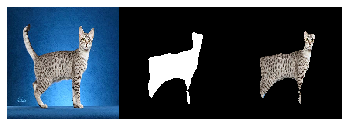

i= 2 loss= 0.6900644560927125 val_loss= 0.7112625458023765 mean_iou= 0.6032636714036061 val_mean_iou= 0.6174977042458274


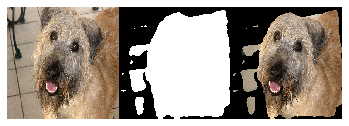

i= 3 loss= 0.6167374138962732 val_loss= 0.5504916364496405 mean_iou= 0.6489205120905349 val_mean_iou= 0.7015888474204324


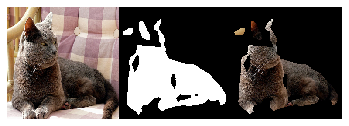

i= 4 loss= 0.5720033657877412 val_loss= 0.49504558606581256 mean_iou= 0.676921335529519 val_mean_iou= 0.7378075068647211


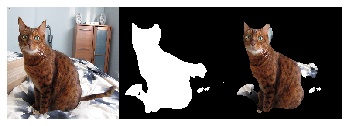

i= 5 loss= 0.5407825195353869 val_loss= 0.5281872234561227 mean_iou= 0.6988231370982514 val_mean_iou= 0.6919068965044889


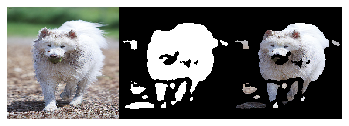

i= 6 loss= 0.52086000491495 val_loss= 0.5036039027300748 mean_iou= 0.7111206541867017 val_mean_iou= 0.7205389954827048


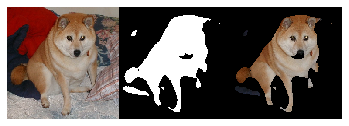

i= 7 loss= 0.5017674103991626 val_loss= 0.4398411078886552 mean_iou= 0.7237916341110996 val_mean_iou= 0.7538993141867898


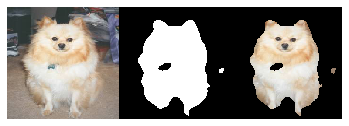

i= 8 loss= 0.48529198520804107 val_loss= 0.5073581879789179 mean_iou= 0.734558121254455 val_mean_iou= 0.709398399699818


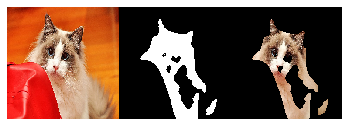

i= 9 loss= 0.4719293469979883 val_loss= 0.4880519590594552 mean_iou= 0.7435896478287162 val_mean_iou= 0.7406371886079962


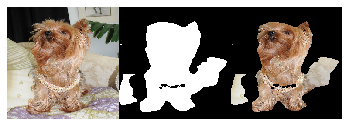

i= 10 loss= 0.46020994883149724 val_loss= 0.43983272259885614 mean_iou= 0.7514559338081918 val_mean_iou= 0.7738491080024026


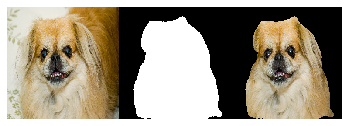

i= 11 loss= 0.4484349319107456 val_loss= 0.6561612324281172 mean_iou= 0.7575788802752211 val_mean_iou= 0.6283296996896918


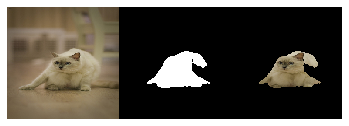

i= 12 loss= 0.43994354221918813 val_loss= 0.42660172419114545 mean_iou= 0.7638213152754797 val_mean_iou= 0.7875234484672546


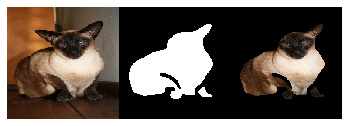

i= 13 loss= 0.4311480571145881 val_loss= 0.46417088129303674 mean_iou= 0.7683212495829961 val_mean_iou= 0.7456084110520103


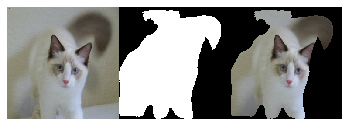

i= 14 loss= 0.4203896443593448 val_loss= 0.4498383646661585 mean_iou= 0.7761234232824142 val_mean_iou= 0.7413028045134111


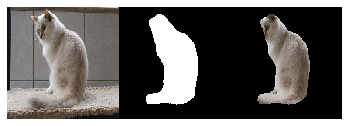

i= 15 loss= 0.41425320846305047 val_loss= 0.41976314241235907 mean_iou= 0.7814518673234878 val_mean_iou= 0.7791276140646501


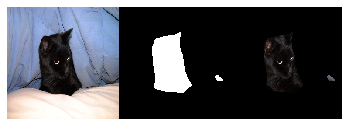

i= 16 loss= 0.40901647433298366 val_loss= 0.42067038200118323 mean_iou= 0.7831814046864096 val_mean_iou= 0.7949026877229864


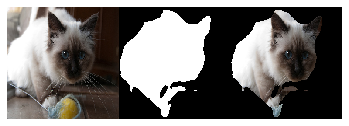

i= 17 loss= 0.3972138461729163 val_loss= 0.4563768614422191 mean_iou= 0.7909728002874818 val_mean_iou= 0.7699894363229925


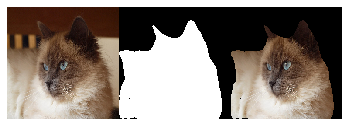

i= 18 loss= 0.39123202785509364 val_loss= 0.3960461535237052 mean_iou= 0.7949600116302978 val_mean_iou= 0.8049349676478993


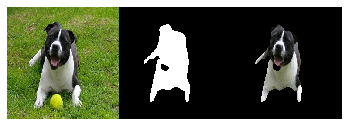

i= 19 loss= 0.3816061010371605 val_loss= 0.4481253136288036 mean_iou= 0.8023310426163347 val_mean_iou= 0.7650182247161865


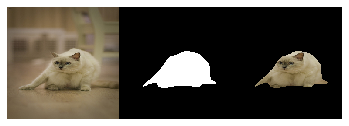

i= 20 loss= 0.378858890027216 val_loss= 0.4780259403315457 mean_iou= 0.8025353322290394 val_mean_iou= 0.7476589192043651


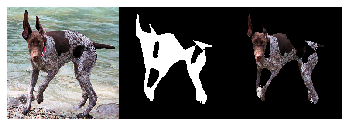

i= 21 loss= 0.3749310068071705 val_loss= 0.44924701072952966 mean_iou= 0.8048408306352625 val_mean_iou= 0.7920977093956687


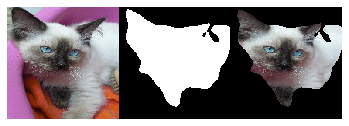

i= 22 loss= 0.3710550382801387 val_loss= 0.4119741212237965 mean_iou= 0.8073444891738021 val_mean_iou= 0.7993025833910162


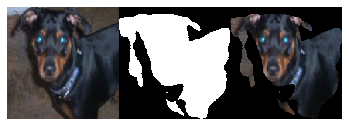

i= 23 loss= 0.36376103622728284 val_loss= 0.44399549744345923 mean_iou= 0.8118146742315597 val_mean_iou= 0.7807101282206449


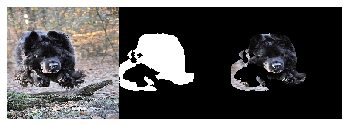

i= 24 loss= 0.3577041103415293 val_loss= 0.42165668173269794 mean_iou= 0.814968971629121 val_mean_iou= 0.8038971153172579


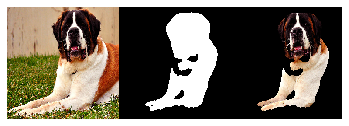

i= 25 loss= 0.35387886060427315 val_loss= 0.4314062134786086 mean_iou= 0.818538764296057 val_mean_iou= 0.7985871650955894


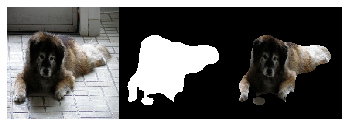

i= 26 loss= 0.34946127678161343 val_loss= 0.49214682524854486 mean_iou= 0.8196298648777618 val_mean_iou= 0.7666895931417291


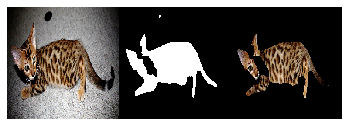

i= 27 loss= 0.3428676966662821 val_loss= 0.4313559288328344 mean_iou= 0.82419450887262 val_mean_iou= 0.7958406535061923


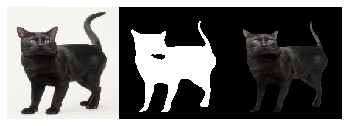

i= 28 loss= 0.33987766068819997 val_loss= 0.44129950079050934 mean_iou= 0.8244916992644741 val_mean_iou= 0.7772403901273554


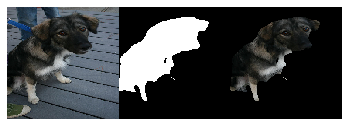

i= 29 loss= 0.3326041600475573 val_loss= 0.4328874403780157 mean_iou= 0.8290344923054247 val_mean_iou= 0.8153292428363453


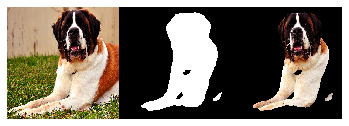

i= 30 loss= 0.33227862778319617 val_loss= 0.4078955433585427 mean_iou= 0.8301277266789789 val_mean_iou= 0.8119734254750338


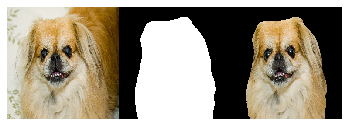

In [19]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [0]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-03-05 12:32:56--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.224.12.41, 13.224.12.16, 13.224.12.69, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.224.12.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.01s   

2020-03-05 12:32:56 (5.53 MB/s) - ‘test.jpg’ saved [63219/63219]



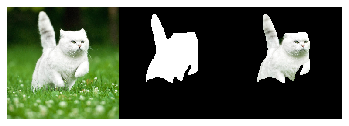

In [0]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

